This file contain the moriginal POLAR framework source code.
Most of them from https://github.com/Sandipan99/POLAR

In [10]:
import gensim
from numpy import linalg
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm_notebook as tqdm
import time
from random import shuffle
import sys
import nltk 
from nltk.corpus import wordnet 
import gc
from collections import defaultdict
import random
import json
import os

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

# Loading the antonyms

In [2]:
current_model = KeyedVectors.load_word2vec_format("./Dataset/word2vec_norm", binary=True)

In [3]:
list_antonym = []

with open('./Dataset/Antonym_sets/LenciBenotto.val') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))


with open('./Dataset/Antonym_sets/LenciBenotto.test') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
with open('./Dataset/Antonym_sets/EVALution.val') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
with open('./Dataset/Antonym_sets/EVALution.test') as fp:
    for line in fp:
        parts = line.split()
        if parts[3]=='antonym':
            word1 = parts[0].split('-')[0]
            word2 = parts[1].split('-')[0]
            if word1 in current_model and word2 in current_model:
                list_antonym.append((word1.strip().lower(), word2.strip().lower()))
                
                
list_antonym = list(dict.fromkeys(list_antonym).keys())

In [4]:
len(list_antonym)

2968

One word may have some different antonyms, so we want to select the best one. Hence, we do some processing for 'list_antonym'.

In [5]:
similarity_matrix = defaultdict(list)
for each_pair in tqdm(list_antonym):
    word1 = each_pair[0]
    word2 = each_pair[1]
    if word1 < word2:
        similarity_matrix[word1].append(word2)
    else:
        similarity_matrix[word2].append(word1)
    
all_similarity = defaultdict(dict)
for each_key in tqdm(similarity_matrix):
    for each_value in similarity_matrix[each_key]:
#         cosine_similarity([current_model[each_key]]
        all_similarity[each_key][each_value] = abs(cosine_similarity([current_model[each_key]],[current_model[each_value]])[0][0])
    
final_antonym_list = []
for index_counter, each_key in enumerate(tqdm(all_similarity)):
#     print(each_key,all_similarity[each_key])
    listofTuples = sorted(all_similarity[each_key].items() ,  key=lambda x: x[1])
#     print(listofTuples)
    final_antonym_list.append((each_key, listofTuples[0][0]))
print(len(final_antonym_list))

list_antonym = final_antonym_list


1411


In [7]:
list_antonym[:5]

[('exclude', 'inscribe'),
 ('assertion', 'lazy'),
 ('beginning', 'terminal'),
 ('lop', 'secure'),
 ('libertine', 'pastor')]

## Decide on the size of the antonym vector

In [8]:
num_antonym = 1411

In [9]:
## Find the antonym difference vectors
# the dir vector of each antonym pair
antonymy_vector = []
for each_word_pair in list_antonym:
    antonymy_vector.append(current_model[each_word_pair[0]]- current_model[each_word_pair[1]])
antonymy_vector = np.array(antonymy_vector)
print(antonymy_vector.shape)

(1411, 300)


## Subset Dimension Selection Method

In [11]:
import random

from scipy.spatial.distance import cosine as scipy_cosine
random.seed(42)

t1 = np.array(antonymy_vector)
#construct a dict for each antonym from antonyms, which includes the cosine value of all antonyms
dimension_similarity_matrix = defaultdict(dict)
# dict of dict
for index_1, each_dim1 in enumerate(tqdm(t1)):
    for index_2, each_dim2 in enumerate(t1):
        #two dimensions dictionary
        dimension_similarity_matrix[index_1][index_2] = abs(1-scipy_cosine(each_dim1, each_dim2))

#final_list contains incies of antonyms, which is the final selected antonyms
# each_dim is another antonym index from original antonyms set
# for each_dim, calculate the score(cosine), which is the mean value for final_list
def get_set_score(final_list, each_dim):
    final_output = 0.0
    for each_vec in final_list:
        final_output += dimension_similarity_matrix[each_vec][each_dim]
    return final_output/(len(final_list))

#num_dim if the number of selected antonyms
#dim_vector.shape(1411,300), it is the original antonyms vector set
def select_subset_dimension(dim_vector, num_dim):
    working_list = np.array(dim_vector)
    
    working_position_index = [i for i in range(working_list.shape[0])]
    final_position_index = [] #store the final index of selected of antonyms
    

    print('working list is ready, shape', working_list.shape)
    # first, randomly selecte a index form original antonyms
    sel_dim = random.randrange(0, working_list.shape[0])

    final_position_index.append(sel_dim)
    
    # delete it from original antonym sets
    working_position_index.remove(sel_dim)

    # select other num_dim-1 antonyms
    for test_count in tqdm(range(num_dim-1)):
        min_dim = None
        min_score = 1000
        for temp_index, each_dim in enumerate(working_position_index):
#             print(each_dim)
            temp_score = get_set_score(final_position_index, each_dim)
        # select the minimal score antonym index form original antonyms set
            if temp_score< min_score:
                min_score= temp_score
                min_dim = each_dim
        print(test_count,min_dim) # min_dim is the index of selected antonym
        final_position_index.append(min_dim)
        working_position_index.remove(min_dim)
#         print(working_list.shape, len(final_list))
    return final_position_index

## Generate the ORTHOGONAL DIMENSION Order

In [12]:
num_antonym = 1411 # the number of antonym want to select
## Find the antonym difference vectors,the dir vector of each antonym pair
#antonymy vector from above
orthogonal_antonymy_vector =np.array(select_subset_dimension(antonymy_vector, num_antonym))  
print(orthogonal_antonymy_vector.shape)

working list is ready, shape (1411, 300)


0 191
1 505
2 1175
3 744
4 80
5 1225
6 1292
7 847
8 508
9 1331
10 1021
11 503
12 968
13 1278
14 446
15 919
16 956
17 11
18 1255
19 46
20 799
21 1165
22 339
23 768
24 411
25 1284
26 1038
27 1161
28 1344
29 223
30 145
31 705
32 1094
33 1329
34 1282
35 1408
36 1405
37 1055
38 1347
39 738
40 452
41 971
42 350
43 27
44 224
45 1343
46 310
47 173
48 583
49 759
50 493
51 222
52 1115
53 741
54 858
55 269
56 619
57 1215
58 624
59 669
60 604
61 1178
62 1150
63 937
64 216
65 617
66 711
67 685
68 883
69 498
70 798
71 948
72 1211
73 1241
74 1042
75 336
76 396
77 525
78 1125
79 898
80 580
81 677
82 355
83 1293
84 120
85 989
86 872
87 621
88 686
89 1129
90 1223
91 240
92 500
93 781
94 1250
95 332
96 5
97 1317
98 155
99 1017
100 144
101 1369
102 1096
103 1361
104 225
105 466
106 1142
107 248
108 53
109 1229
110 998
111 1158
112 87
113 563
114 1402
115 941
116 1326
117 77
118 1029
119 1335
120 1245
121 1383
122 1200
123 1118
124 725
125 1050
126 1136
127 325
128 1376
129 1396
130 1162
131 574
132 496
13

In [15]:
print(orthogonal_antonymy_vector)

[1309  191  505 ...  142 1159 1244]


## Generate the RANDOM DIMENSION Order

In [42]:
random_antonym_vector = [i for i in range(len(antonymy_vector))]
random.shuffle(random_antonym_vector)
print(len(random_antonym_vector))

1411


## Generate the MAXIMUM VARIANCE DIMENSION Order

In [34]:
embedding_size = antonymy_vector.shape[0]   
print('The embedding size is', embedding_size)

#calcaulate Moore-Penrose inverse
#np.transpose 矩阵转置
variance_antonymy_vector_inverse = np.linalg.pinv(np.transpose(antonymy_vector))

embedding_matrix = []

#calcaulate new vector for each word in Vocab
total_words = 0
for each_word in tqdm(current_model.vocab):
    total_words += 1
    #multiple
    new_vector = np.matmul(variance_antonymy_vector_inverse,current_model[each_word])
    
    embedding_matrix.append(new_vector)

The embedding size is 1411


In [21]:
print(len(embedding_matrix)) # how many words
print(len(embedding_matrix[0])) # how many diemensions of each word

212390
1411


In [23]:
del new_vector

In [35]:
variance_list = []

embedding_matrix = np.array(embedding_matrix)
print(len(embedding_matrix[:,1]))
#calcaulate variance for each colunms, 1411 colunms , 1411 variances
for each_dimension in tqdm(range(embedding_matrix.shape[1])):
    variance_list.append(np.var(embedding_matrix[:,each_dimension]))

212390


In [30]:
variance_antonymy_vector = [each for each in sorted(range(len(variance_list)), key=lambda i: variance_list[i], reverse=True)]
# print(variance_antonymy_vector)
# store index of each antonym, descending order by varinace
print(len(variance_antonymy_vector))

1411


In [36]:
del embedding_matrix
del variance_list

# Transformation to polar space¶

In [37]:
def transform_to_antonym_space(current_model, output_file_path, binary, current_antonymy_vector_inverse):
    #current_antonymy_vector_inverse is ((dir)T)-1
    #embeddding_size is dynamic, it depends on how many antonym pairs we have selected
    embedding_size = current_antonymy_vector_inverse.shape[0]   ##CHANGE THIS ACCORDINGLY!!!
    print('New model size is',len(current_model.vocab), embedding_size)

    temp_file = None
    
    if binary:
        temp_file = open(output_file_path,'wb')
        temp_file.write(str.encode(str(len(current_model.vocab))+' '+str(embedding_size)+'\n'))
    else:
        temp_file = open(output_file_path,'w')
        temp_file.write(str(len(current_model.vocab))+' '+str(embedding_size)+'\n')

    total_words = 0
    for each_word in tqdm(current_model.vocab):
        total_words += 1
        if binary:
            temp_file.write(str.encode(each_word+' '))
        else:
            temp_file.write(each_word+' ')

        new_vector = np.matmul(current_antonymy_vector_inverse,current_model[each_word])
        # normalization vector
        new_vector = new_vector/linalg.norm(new_vector)

        
        
        if binary:
            temp_file.write(new_vector)
            temp_file.write(str.encode('\n'))
        else:
            temp_file.write(str(new_vector))
            temp_file.write('\n')


    temp_file.close()

# Standard normal transform

In [38]:
#standard normalization for word vectors
#Standardization makses datapoint normal distribution
def standard_normal_dist_model(model, new_filename):
    embedding_matrix = []
    embedding_vocab = []

    temp_file = open(new_filename,'wb')
    temp_file.write(str.encode(str(model.vectors.shape[0])+' '+str(model.vectors.shape[1])+'\n'))
    
    for each_word in tqdm(model.vocab):
        embedding_matrix.append(model[each_word])
        embedding_vocab.append(each_word)
    
    embedding_matrix = np.array(embedding_matrix)
    
    print('The shape of embedding matrix is {}'.format(embedding_matrix.shape))
    
    #standard normalization
    norm_embedding_matrix = (embedding_matrix - embedding_matrix.mean(0))/ embedding_matrix.std(0)
    
    for word_counter, each_word in enumerate(tqdm(embedding_vocab)):
#         assert each_word==embedding_vocab[word_counter],'Not matching!!!'
        
        temp_file.write(str.encode(each_word+' '))
        new_vector = norm_embedding_matrix[word_counter]
        temp_file.write(new_vector)
        temp_file.write(str.encode('\n'))
        
    del embedding_matrix
    del embedding_vocab
    temp_file.close()

# generate different diemension size

In [46]:
def generate_embedding_path(current_model, embedding_path, binary, antonym_vector, curr_dim):
    curr_antonym_vector = antonymy_vector[antonym_vector[:curr_dim]]
    print('***',curr_antonym_vector.shape)
    #calcaulate Moore-Penrose inverse
    #np.transpose 矩阵转置
    curr_antonymy_vector_inverse = np.linalg.pinv(np.transpose(curr_antonym_vector))
    print('###',curr_antonymy_vector_inverse.shape)
    transform_to_antonym_space(current_model, embedding_path, binary,curr_antonymy_vector_inverse)

In [44]:
import subprocess
dim_size = 500 # Number of POLAR dimenions(selected antonym pairs)
# thers are three methods
antonym_vector_method = random_antonym_vector # orthogonal_antonymy_vector, variance_antonymy_vector

In [47]:
curr_dim = dim_size

embedding_path = './Dataset/rand_antonym_'+str(curr_dim)+'.bin'
generate_embedding_path(current_model, embedding_path,True,random_antonym_vector, curr_dim)

print('loading the model')
temp_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path, binary=True)
print('loading done..')

std_nrml_embedding_path = './Dataset/rand_antonym_gl_'+str(curr_dim)+'_StdNrml.bin'
standard_normal_dist_model(temp_model, std_nrml_embedding_path)

*** (500, 300)
### (500, 300)
New model size is 212390 500



loading the model
loading done..



The shape of embedding matrix is (212390, 500)


In [79]:
std_500_path = './Dataset/rand_antonym_gl_500_StdNrml.bin'
norm_500_path = './Dataset/rand_antonym_500.bin'
#loading new word vectors
norm_500_vector = gensim.models.KeyedVectors.load_word2vec_format(norm_500_path, binary=True)
std_500_vector = gensim.models.KeyedVectors.load_word2vec_format(std_500_path, binary=True)

In [82]:
std_500_vector.most_similar('friend')

[('strange', 0.5067113041877747),
 ('acquaintance', 0.4197438657283783),
 ('colleague', 0.4075758457183838),
 ('classmate', 0.4074922800064087),
 ('timey', 0.38640278577804565),
 ('mcnasty', 0.3738652467727661),
 ('mentor', 0.37134453654289246),
 ('jellystone', 0.36943215131759644),
 ('friendship', 0.36779552698135376),
 ('lover', 0.36224639415740967)]

In [59]:
norm_500_vector.most_similar('wang')
print(norm_500_vector['wang'][0])

0.00675154


In [62]:
random_select_antonyms = [list_antonym[index] for index in random_antonym_vector[:500]]
print(random_select_antonyms[:5])
print(len(random_select_antonyms))

[('ordinary', 'rare'), ('arbor', 'mat'), ('disgust', 'please'), ('cold', 'friendly'), ('punishment', 'reward')]
500


In [85]:
this_vector = std_500_vector['water']
this_dict = {}
for index,value in enumerate(this_vector):
    this_dict[index] = value
    
sorted_this_dict = sorted(this_dict.items(), key= lambda item : abs(item[1]), reverse=True )
for key,value in sorted_this_dict[:5]:
    print(value)
    print(key)
    print(random_select_antonyms[key])

-6.496165
181
('sky', 'water')
-6.4502506
466
('grass', 'water')
5.934052
246
('water', 'wood')
-4.7093353
390
('iodine', 'water')
2.8280227
347
('puddle', 'snowball')


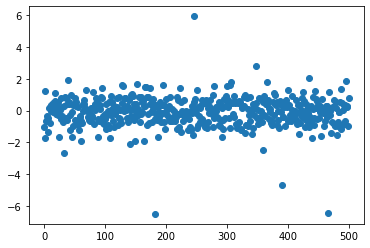

In [87]:
import matplotlib.pyplot as plt

X = [i for i in range(len(this_vector))]
Y = this_vector
plt.scatter(X, Y)
plt.show()

In [88]:
def plotPolar(left, right, value):
    fig, ax1 = plt.subplots()
    fig.set_figheight(1)
    fig.set_figwidth(10)

    val = 0
    ar = np.arange(-10,11) 
    ax1.plot(ar, np.zeros_like(ar) + val, '.')
    ax1.plot(value, 0, 'd', linewidth=2, markersize=20, color='r')
    ax1.set_ylabel(left, color='b',rotation=0, size=20, labelpad=50)
    ax1.set_yticks([])
    ax1.set_xticks(ar)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)

    ax2 = ax1.twinx()
    ax2.set_ylabel(right, color='r',rotation=0, size=20, labelpad=50)
    ax2.set_yticks([])
    ax1.grid(False)
    ax2.grid(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    
    
    fig.tight_layout()
    plt.show()

In [90]:
import matplotlib.pyplot as plt

def getMeaningOfWord(word, antonyms, model, show_polars ):
    
    this_vector = model[word]
    this_dict = {}
    for index,value in enumerate(this_vector):
        this_dict[index] = value
    
    sorted_this_dict = sorted(this_dict.items(), key= lambda item : abs(item[1]), reverse=True )
    
    for i,v in sorted_this_dict[:show_polars]:
        cur_value = v
        leftPolar = antonyms[i][0]
        rightPolar = antonyms[i][1]
        plotPolar(rightPolar,leftPolar, cur_value)
        

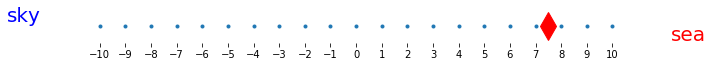

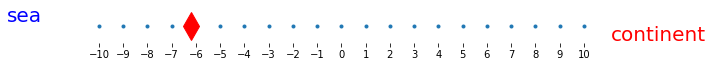

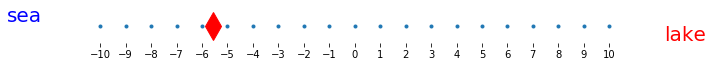

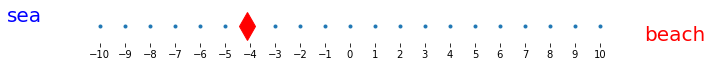

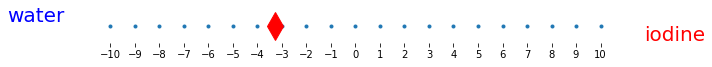

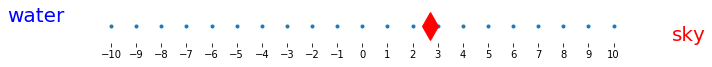

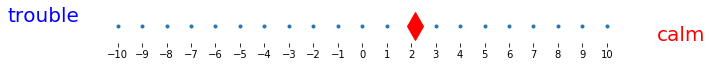

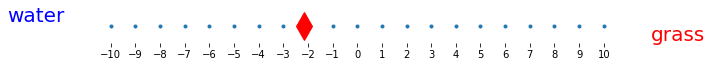

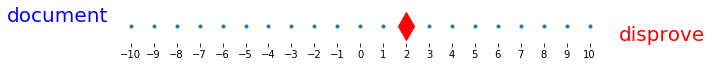

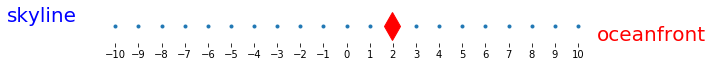

In [94]:
getMeaningOfWord("sea",random_select_antonyms, std_500_vector, 10 )